# Robust Production Planning

The purpose of this notebook is to demonstrate a range of techniques for robust optimization using a common example.

* Constraint and Column Generation (Section 10.1)
* Stochastic Optimization
* Progressive Hedging in Pyomo Overview: https://www.osti.gov/servlets/purl/1524963

In [2]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_cbc()

pyomo was previously installed
cbc was previously installed


True

## Multi-product factory (adapted from Chapter 3)

A small startup company has announced the initial production of two models, $U$ and $V$ of a new product. Here is what they know about the production of $U$ and $V$:

* Product $U$ is the higher priced model that requires 10 units of raw material. The labor requirement is estimated to be 1 hour of labor A and 2 hours of labor B. Product $U$ will sell for 270€ per unit.

* Product $V$ requires 9 units of the same raw materials and estimated to require 1 hour of labor A and 1 hour of labor B. Product $V$ sells for 210€ per unit with unlimited demand.

* The initial marketing campaign offers guaranteed delivery of model $U$ in return for a down payment. The number of units to be sold with a delivery guarantee is unknown, but will be limited to 20 units. Demand is limited to 40 units.

* Raw material costs a 10€ per unit. The raw materials have a long lead time and must be ordered now. Unused raw materials have no waste value. 

* Given current staffing, there are 80 hours per day of labor A available at a cost of 50€/hour, and 100 hours per day of labor B available at a cost of 40€/hour.

* The company will not have not accurate knowledge of the labor required to produce each product until production starts. The estimated amount of labor A and labor B needed for each unit produced could be off by 20% and 40%, respectively. The uncertainty for labor A is independent of the uncertainty associated with labor B.

The operator must decide how much raw material to order without complete information about labor needed to manufacture the products, or knowledge about the outcome of the marketing campaign. If the operator orders too much then raw material will be left over and wasted. If the operator orders too little then some of the labor resources will go unused and wasted. In either case, the profit realized will be less than than the potential.

How much raw material should the company order now?

## What is the worst-case?

The problem outlines three sources of uncertainty:

* $z_A$: Relative uncertainty in the amount of labor A required to produce each unit of product.
* $z_B$: Relative uncertainty is the amount of labor B required to produce each unit of product.
* $z_U$: Uncertainty in number initial orders for product $U$.

where

$$\begin{align}
|z_A| & \leq 0.20 && \pm\text{20% uncertainty in Labor }A \\
|z_B| & \leq 0.40 && \pm\text{40% uncertainty in Labor }B \\
z_U & \leq 20 &&  \text{uncertainty in initial orders for }U \\
\end{align}$$

If production is not constrained, the unit profit for each device would be given by

$$
\begin{align}
P_U & = 270 - 50(1+z_A) - 80(1+z_B) - 100) \\
& = 40 - 50 z_A - 80 z_B \\
\implies P_U & \in [-2, 82] \\
\\
P_V & = 210 - 50(1+z_A) - 40(1+z_B) - 90) \\
& = 30 - 50 z_A - 40 z_B \\
\implies P_V  & \in [4, 56]
\end{align}
$$

The impact of uncertainty associated with initial orders, $z_U$, depends on $z_A$, $z_B$, and the sensitivity of the optimal profit to the incremental production of $U$ and $V$ under constraints makes is difficult to determine, *apriori*, the worst-case operating conditions.

## Model for nominal conditions

To establish a baseline for this problem, we start with a simple model for operation under nominal conditions.

$$
\begin{align*}
\max_{w, x, y \geq 0} \quad & - 10 w + 140 u + 120 v \\
\text{s.t.} \quad & u  \leq 40 && \text{(demand)}\\
& u + v \leq 80 && \text{(labor A)}\\
& 2 u +  v \leq 100 && \text{(labor B)}\\
& -w + 10 u + 9 v  \leq 0 && \text{(raw materials)} \\
\end{align*}
$$

We can see that $w = 10 u + 9 v$ at an optimum, so that 

$$J = (40 - 50 z_A - 80 z_B)u + (30 - 50 z_A - 40 z_B)v$$



In [3]:
import pyomo.environ as pyo

m = pyo.ConcreteModel()

m.w = pyo.Var(domain=pyo.NonNegativeReals)
m.u = pyo.Var(domain=pyo.NonNegativeReals)
m.v = pyo.Var(domain=pyo.NonNegativeReals)

@m.Constraint()
def demand(m):
    return m.u <= 40

@m.Constraint()
def labor_A(m):
    return m.u + m.v <= 80

@m.Constraint()
def labor_B(m):
    return 2*m.u + m.v <= 100

@m.Constraint()
def raw_materials(m):
    return -m.w + 10*m.u + 9*m.v <= 0

@m.Objective(sense=pyo.maximize)
def profit(m):
    return - 10*m.w + 140*m.u + 120*m.v

solver = pyo.SolverFactory('cbc')
solver.solve(m)

m.profit.display()
m.w.display()
m.u.display()
m.v.display()

profit : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 2600.0
w : Size=1, Index=None
    Key  : Lower : Value : Upper : Fixed : Stale : Domain
    None :     0 : 740.0 :  None : False : False : NonNegativeReals
u : Size=1, Index=None
    Key  : Lower : Value : Upper : Fixed : Stale : Domain
    None :     0 :  20.0 :  None : False : False : NonNegativeReals
v : Size=1, Index=None
    Key  : Lower : Value : Upper : Fixed : Stale : Domain
    None :     0 :  60.0 :  None : False : False : NonNegativeReals


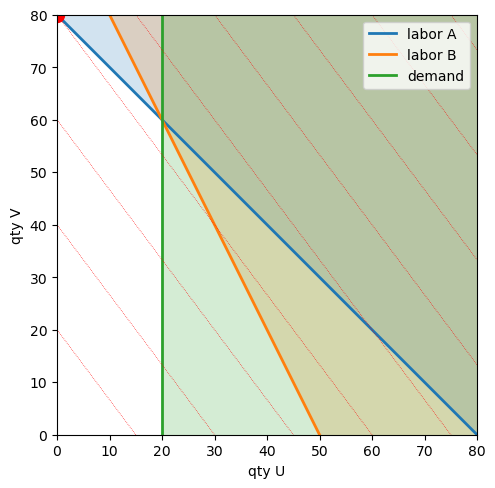

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pyomo.environ as pyo

z_A = 0
z_B = 0
z_D = -.5

m = pyo.ConcreteModel()

m.w = pyo.Var(domain=pyo.NonNegativeReals)
m.u = pyo.Var(domain=pyo.NonNegativeReals)
m.v = pyo.Var(domain=pyo.NonNegativeReals)

@m.Constraint()
def demand(m):
    return m.u <= 40*(1 + z_D)

@m.Constraint()
def labor_A(m):
    return m.u*(1 + z_A) + m.v*(1 + z_A) <= 80

@m.Constraint()
def labor_B(m):
    return 2*m.u*(1 + z_B) + m.v*(1 + z_B) <= 100

@m.Constraint()
def raw_materials(m):
    return -m.w + 10*m.u + 9*m.v <= 0

@m.Objective(sense=pyo.maximize)
def profit(m):
    return - 10*m.w + (140 - 50*z_A - 80*z_B)*m.u + (120 - 50*z_D - 40*z_B)*m.v

solver = pyo.SolverFactory('cbc')
solver.solve(m)

fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(211, xlabel="qty U", ylabel="qty V", 
                 aspect=1, xlim=(0, 80), ylim=(0, 80))

u = np.linspace(0, 80)

ax.plot(u, (80 - u*(1 + z_B))/(1 + z_B), lw=2, label="labor A")
ax.plot(u, (100 - 2*u*(1 + z_B))/(1 + z_B), lw=2, label="labor B")
ax.plot([40*(1 + z_D)]*2, ax.get_ylim(), lw=2, label="demand")

ax.fill_between(u, (80 - u*(1 + z_B))/(1 + z_B), 100, alpha=0.2)
ax.fill_between(u, (100 - 2*u*(1 + z_B))/(1 + z_B), 100, alpha=0.2)
ax.fill_between([40*(1 + z_D), ax.get_xlim()[1]], [0]*2, [100]*2, alpha=0.2)

ax.legend(loc="upper right")

for profit in [600*k for k in range(20)]:
    ax.plot(u, (profit - 40*u)/30, 'r:', alpha=1, lw=0.5)

ax.plot(m.u.value, m.v.value, 'r.', ms=20)

Next we formulate the robust optimization problem where the objective is to maximize the worst case profit subject to constraints and uncertainty. 

$$\begin{align}
\max \quad & -10 w + \tau \\
\text{s.t.}\quad & (140 - 50z_A - 80z_B) u + (120 - 50z_A - 40z_B) v \geq  \tau && \text{(worst-case profit)} \\
& u \leq 40(1 + z_D) && \text{(demand)}\\
& (1 + z_A) u + (1 + z_B) v \leq 80 && \text{(labor A)} \\
& 2 (1 + z_A) u + (1 + z_B) v \leq 100 && \text{(labor B)} \\
& -w + 10 u + 9 v \leq 0 && \text{(raw materials)} \\
\end{align}$$

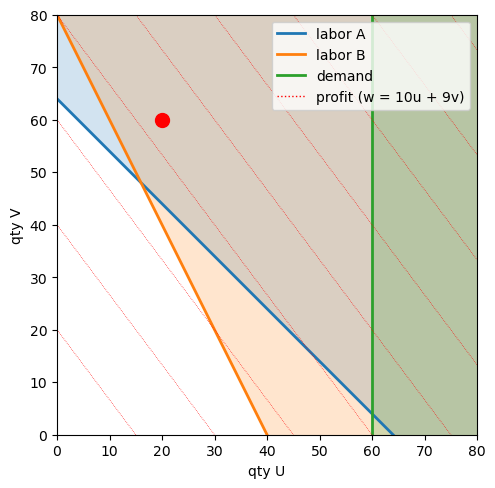

In [13]:
import matplotlib.pyplot as plt
import numpy as np

z_A = 0.15
z_B = 0.25
z_D = 0.5

fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(211, xlabel="qty U", ylabel="qty V", 
                 aspect=1, xlim=(0, 80), ylim=(0, 80))

u = np.linspace(0, 80)

ax.plot(u, (80 - u*(1 + z_B))/(1 + z_B), lw=2, label="labor A")
ax.plot(u, (100 - 2*u*(1 + z_B))/(1 + z_B), lw=2, label="labor B")
ax.plot([40*(1 + z_D)]*2, ax.get_ylim(), lw=2, label="demand")

ax.fill_between(u, (80 - u*(1 + z_B))/(1 + z_B), 100, alpha=0.2)
ax.fill_between(u, (100 - 2*u*(1 + z_B))/(1 + z_B), 100, alpha=0.2)
ax.fill_between([40*(1 + z_D), ax.get_xlim()[1]], [0]*2, [100]*2, alpha=0.2)

ax.plot(0, 0, 'r:', alpha=1, lw=1, label="profit (w = 10u + 9v)")
ax.legend(loc="upper right")

for profit in [600*k for k in range(20)]:
    ax.plot(u, (profit - 40*u)/30, 'r:', alpha=1, lw=0.5)

ax.plot(m.u.value, m.v.value, 'r.', ms=20)

## Two-stage robust optimization (cf. Section 10.1)

Next we formulate the robust optimization problem where the objective is to maximize the worst case profit subject to constraints and uncertainty. 

$$\begin{align}
\max \quad & -10 w + \tau \\
\text{s.t.}\quad & (140 - 50z_A - 80z_B) u + (120 - 50z_A - 40z_B) v \geq  \tau && \text{(worst-case profit)} \\
& u \leq 40(1 + z_D) && \text{(demand)}\\
& (1 + z_A) u + (1 + z_B) v \leq 80 && \text{(labor A)} \\
& 2 (1 + z_A) u + (1 + z_B) v \leq 100 && \text{(labor B)} \\
& -w + 10 u + 9 v \leq 0 && \text{(raw materials)} \\
\end{align}$$

where

$$\begin{align}
|z_A| & \leq 0.15 && \pm\text{15% uncertainty in Labor }A \\
|z_B| & \leq 0.25 && \pm\text{25% uncertainty in Labor }B \\
|z_D| & \leq 0.50 && \pm\text{50% uncertainty in demand } \\
\end{align}$$

This is a system in the form

$$\begin{align}
\max\limits_{x, y, \tau} \quad & c^\top x + \tau \\
\text{s.t.} \quad & q(z)^\top y \geq \tau \\
& C (z) x + D(z) y \leq e(z)
\end{align}$$

where $x$, $y$, and $z$ are the first-stage, second-stage, and uncertainty variables, respectively. Note t

$$
x = \begin{pmatrix} w \end{pmatrix}
\quad
y = \begin{pmatrix} u \\ v \end{pmatrix}
\quad
z = \begin{pmatrix} z_A \\ z_B \\ z_D \end{pmatrix}
$$

Then defining

$$
c = \begin{pmatrix} -10 \end{pmatrix}
$$

$$
q(z) = \begin{pmatrix} 140 - 50z_A - 80z_B \\ 120 - 50z_A - 40z_B \end{pmatrix} \\
$$

$$
C(z)  = \begin{pmatrix} 0 \\ 0 \\ 0 \\ -1 \end{pmatrix} 
\quad
D(z) = \begin{pmatrix} 1 & 0 \\ 1+z_A & 1 + z_A \\ 2(1+z_B) & 1 + z_B \\ 10 & 9 \end{pmatrix}
\quad
e(z) = \begin{pmatrix} 40(1+z_D) \\ 80 \\ 100 \\ 0 \end{pmatrix} \\
$$

The following cell is a function that evaluates the system matrix coefficients for a particular $z\in Z$ and returns numerical values indexed in nested dictionaries.


In [170]:
# function to return c, q, C, D, e evaluated for a scenario

def model_params(z_A=0, z_B=0, z_D=0):
    
    c = {"w": -10}

    q = {"u": 140 - 50*z_A - 80*z_B,
         "v": 120 - 50*z_A - 40*z_B}

    C = {"demand" : {"w": 0},
         "labor A": {"w": 0},
         "labor B": {"w": 0},
         "raw materials": {"w": -1}}

    D = {"demand": {"u": 1, "v": 0},
         "labor A": {"u": 1, "v": 1 + z_A},
         "labor B": {"u": 2 + 2 * z_B, "v": 1 + z_B},
         "raw materials": {"u": 10, "v": 9}}

    e = { "demand": 40 * (1 + z_D),
          "labor A": 80,
          "labor B": 100,
          "raw materials": 0}

    return c, q, C, D, e

c, q, C, D, e = model_params()

print(f"c = {c}")
print(f"q = {q}")
print(f"C = {C}")
print(f"D = {D}")
print(f"e = {e}")

c = {'w': -10}
q = {'u': 140, 'v': 120}
C = {'demand': {'w': 0}, 'labor A': {'w': 0}, 'labor B': {'w': 0}, 'raw materials': {'w': -1}}
D = {'demand': {'u': 1, 'v': 0}, 'labor A': {'u': 1, 'v': 1}, 'labor B': {'u': 2, 'v': 1}, 'raw materials': {'u': 10, 'v': 9}}
e = {'demand': 40, 'labor A': 80, 'labor B': 100, 'raw materials': 0}


The next cell creates a Pyomo model to maximize the worst case profit for a set of scenarios.

In [182]:
import pyomo.environ as pyo
import numpy as np

def max_min_profit(model_params, Z):
    
    m = pyo.ConcreteModel()

    # first stage variables
    c, *_ = model_params()
    m.x = pyo.Var(c.keys(), domain=pyo.NonNegativeReals)
    m.t = pyo.Var()
    
    m.SCENARIOS = pyo.Set(initialize=range(len(Z)))
    
    @m.Block(m.SCENARIOS)
    def scenario(b, s):

        # get model parameters for the scenario
        c, q, C, D, e = model_params(**Z[s])
        
        # second stage variables
        b.y = pyo.Var(q.keys(), domain=pyo.NonNegativeReals)
        
        # profit for each scenaario
        @b.Expression()
        def profit(b, s):
            return sum(c[i] * b.model().x[i] for i in c.keys()) + sum(q[j] * b.y[j] for j in q.keys())

        @b.Constraint()
        def stage_net_profit(b):
            return sum(q[j] * b.y[j] for j in q.keys()) >= b.model().t

        @b.Constraint(D.keys())
        def model_constraints(b, k):
            return  sum(C[k][i]*b.model().x[i] for i in c.keys()) + sum(D[k][j]*b.y[j] for j in q.keys()) <= e[k]
    
    # worst case profit
    @m.Objective(sense=pyo.maximize)
    def min_profit(m):
        return sum(c[i] * m.x[i] for i in c.keys()) + m.t
    
    solver = pyo.SolverFactory('cbc')
    solver.solve(m)
    return m

m = max_min_profit(model_params, [{"z_A": 0, "z_B":0, "z_D": 0}])
m.min_profit.display()
m.x.display()

for s in m.SCENARIOS:
    print(f"{s:4d}: {m.scenario[s].profit.expr()}")
    

min_profit : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 2600.0
x : Size=1, Index=x_index
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      w :     0 : 740.0 :  None : False : False : NonNegativeReals
   0: 2600.0


## Random Scenarios


$$
\begin{align}
\max\limits_{x, y^1, \ldots, j^k, \tau} \quad & c^\top x + \tau \\
\text{s.t.} \quad & q(z^j)^\top y^j \geq \tau, && j = 1, \ldots, k \\
& C (z^j) x + D(z^j) y^j \leq e(z^j)  &&  j = 1, \ldots, k
\end{align}
$$


In [221]:
k =1000

Z = [{"z_A": 0.15*np.random.uniform(-1, 1),
      "z_B": 0.25*np.random.uniform(-1, 1),
      "z_D": 0.5*np.random.uniform(-1, 1)} for j in range(k)]

In [222]:
m = max_min_profit(model_params, Z)
m.min_profit.display()
m.x.display()

min_profit : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 951.5439999999999
x : Size=1, Index=x_index
    Key : Lower : Value     : Upper : Fixed : Stale : Domain
      w :     0 : 650.64567 :  None : False : False : NonNegativeReals


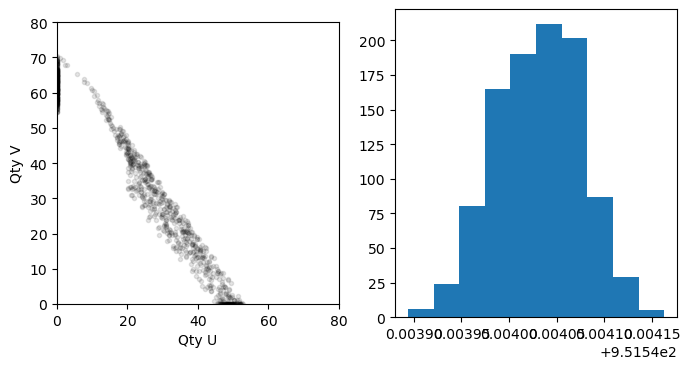

In [223]:
fig = plt.figure(figsize=(8, 4))

ax = plt.subplot(121, aspect=1, xlabel="Qty U", ylabel="Qty V", xlim=(0, 80), ylim=(0, 80))
for s in m.SCENARIOS:
    ax.plot(m.scenario[s].y["u"].value, m.scenario[s].y["v"].value, 'k.', alpha=0.1)
    
ax = plt.subplot(122)
ax.hist([m.scenario[s].profit.expr() for s in m.SCENARIOS]);


## Comparing solution for expected profit to maximum worst-case profit

Assuming equiprobable scenarios, let $r_j$ be the net revenue from the the $j^{th}$ scenario.

$$
\begin{align}
\max\limits_{x, y^1, \ldots, j^k, \tau} \quad & c^\top x + \frac{1}{k}\sum_{j=1}^k r_j \\
\text{s.t.} \quad & q(z^j)^\top y^j = r_j && j = 1, \ldots, k \\
& C (z^j) x + D(z^j) y^j \leq e(z^j)  &&  j = 1, \ldots, k
\end{align}
$$


In [227]:
import pyomo.environ as pyo
import numpy as np

def expected_profit(model_params, Z):
    
    m = pyo.ConcreteModel()
    
    # first stage variables
    c, *_ = model_params()
    m.x = pyo.Var(c.keys(), domain=pyo.NonNegativeReals)

    m.SCENARIOS = pyo.Set(initialize=range(len(Z)))
    
    @m.Block(m.SCENARIOS)
    def scenario(b, s):

        # get model parameters
        c, q, C, D, e = model_params(**Z[s])
        
        # second stage variables and constraints
        b.y = pyo.Var(q.keys(), domain=pyo.NonNegativeReals)
        b.r = pyo.Var()
        
        @b.Constraint()
        def profit(b):
            return sum(q[j] * b.y[j] for j in q.keys()) == b.r

        @b.Constraint(D.keys())
        def stage_two(b, k):
            return  sum(C[k][i]*b.model().x[i] for i in c.keys()) + sum(D[k][j]*b.y[j] for j in q.keys()) <= e[k]
                   
    @m.Expression(m.SCENARIOS)
    def profit(m, s):
        return sum(c[i] * m.x[i] for i in c.keys()) + m.scenario[s].r
    
    @m.Objective(sense=pyo.maximize)
    def expected_profit(m):
        return sum(m.profit[s] for s in m.SCENARIOS) / len(m.SCENARIOS)

    solver = pyo.SolverFactory('cbc')
    solver.solve(m)
    return m

m = max_min_profit(model_params, [{"z_A": 0, "z_B":0, "z_D": 0}])
m.min_profit.display()


min_profit : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 2600.0


In [225]:
m = expected_profit(model_params, Z)
m.expected_profit.display()
m.x.display()
m.pprint()

expected_profit : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 2511.2366255999978
x : Size=1, Index=x_index
    Key : Lower : Value     : Upper : Fixed : Stale : Domain
      w :     0 : 708.26336 :  None : False : False : NonNegativeReals
2 Set Declarations
    SCENARIOS : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any : 1000 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 13

26.198683
7.0560933
0.0
20.757514
20.068052
14.827905
31.3327
9.48064
28.017703
6.2784533
17.439045
34.541082
32.33126
0.0
43.048848
31.745528
16.014391
23.863172
0.0
17.308388
28.067321
24.247131
48.600621
31.31583
45.365929
30.115037
6.4890862
13.22725
31.320777
33.915857
42.191805
16.497871
19.735968
10.734789
39.523543
11.892533
22.428385
18.980668
24.909472
20.712239
15.292546
28.815323
24.54802
9.9810791
2.737986
0.0
27.485174
50.134804
0.0
13.501614
33.912289
0.0
10.816643
2.9431181
9.2412851
34.331304
12.025608
24.151304
10.801697
16.251797
7.1420725
14.855333
0.0
13.190102
17.035114
28.074437
38.457392
33.104434
8.8997477
18.030732
34.273589
15.075443
32.923047
27.821987
48.7007
0.0
39.867193
6.9169826
16.749185
17.810623
14.425185
7.8925999
0.0
31.134832
14.866129
41.381879
28.093972
36.119335
15.594153
42.330463
31.055116
10.547169
22.67241
10.610095
30.81574
27.572791
24.727445
54.521721
38.861688
21.83798
22.566875
10.040019
4.4096529
30.646867
21.169396
27.425691
0.0
27.4

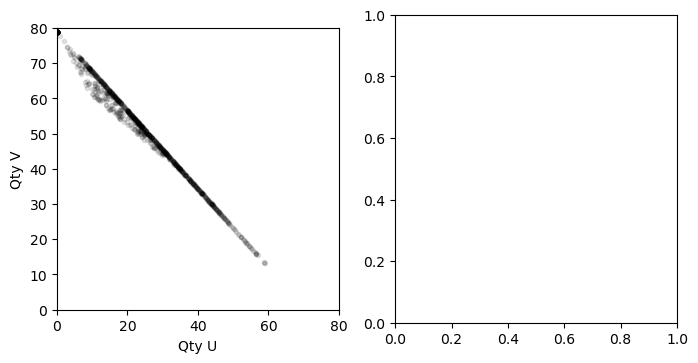

In [226]:
fig = plt.figure(figsize=(8, 4))

ax = plt.subplot(121, aspect=1, xlabel="Qty U", ylabel="Qty V", xlim=(0, 80), ylim=(0, 80))
for s in m.SCENARIOS:
    print(m.scenario[s].y["u"].value)
    ax.plot(m.scenario[s].y["u"].value, m.scenario[s].y["v"].value, 'k.', alpha=0.1)
    
ax = plt.subplot(122)
#ax.hist([m.profit[s].expr() for s in m.scenario_index], bins=30);


In [79]:
c, q, C, D, e = model_params()

Y = [{j: m.scenario[s].y[j].value for j in q.keys()} for s in m.scenario_index]

scenarios

    

[{'z_A': -0.03316713730302071,
  'z_B': -0.0935895262028687,
  'z_D': -0.022119736785979227},
 {'z_A': 0.013649891238735933,
  'z_B': 0.23338552072834395,
  'z_D': -0.4023640268705089},
 {'z_A': 0.04277130006208137,
  'z_B': -0.00943817323040319,
  'z_D': -0.43243088193918255},
 {'z_A': -0.05780026556288324,
  'z_B': -0.07456817543069849,
  'z_D': -0.46498458817852706},
 {'z_A': 0.14554314979033195,
  'z_B': -0.0671782361023805,
  'z_D': 0.38720368047115894},
 {'z_A': -0.05976408216725937,
  'z_B': -0.06349330631571376,
  'z_D': 0.3161449953705818},
 {'z_A': 0.10115414568836438,
  'z_B': -0.029602041171269633,
  'z_D': -0.4090274722090892},
 {'z_A': -0.10870025939872262,
  'z_B': 0.225911374830014,
  'z_D': 0.1938494302171776},
 {'z_A': -0.10608898329927333,
  'z_B': 0.24655123350828562,
  'z_D': 0.2109489661481705},
 {'z_A': -0.054852154619214395,
  'z_B': -0.021450112451789904,
  'z_D': 0.4518067842758253}]

## Deprecated

In [249]:
import pyomo.environ as pyo
import numpy as np

def produce(scenarios=[{"z_A": 0, "z_B":0, "z_D": 0}]):

    m = pyo.ConcreteModel()

    # first stage variables
    m.I = pyo.Set(initialize=["w"])
    m.x = pyo.Var(m.I, domain=pyo.NonNegativeReals)
    m.t = pyo.Var()

    # first stage objective
    m.c = pyo.Param(m.I, initialize={"w": 10})

    @m.Objective()
    def min_profit(m):
        return sum(m.c[i] * m.x[i] for i in m.I) + m.t
    
    # second stage variables and constraints
    m.scenarios = pyo.Param(range(len(scenarios)), domain=pyo.Any, initialize=scenarios)

    @m.Block(m.scenarios_index)
    def scenario(b, s):
        
        b.z_A = b.model().scenarios[s]["z_A"]
        b.z_B = b.model().scenarios[s]["z_B"]
        b.z_D = b.model().scenarios[s]["z_D"]

        b.J = pyo.Set(initialize=["U", "V"])
        b.K = pyo.Set(initialize=["demand", "labor A", "labor B", "raw materials"])

        b.q = pyo.Param(b.J, initialize={
            "U": -140 + 50*b.z_A + 80*b.z_B,
            "V": -120 + 50*b.z_A + 40*b.z_B
        })

        b.C = pyo.Param(b.K, b.model().I, initialize={
            ("demand", "w"): 0, 
            ("labor A", "w"): 0, 
            ("labor B", "w"): 0, 
            ("raw materials", "w"): -1
        })

        b.D = pyo.Param(b.K, b.J, initialize={
            ("demand", "U"): 1, 
            ("demand", "V"): 0,
            ("labor A", "U"): 1, 
            ("labor A", "V"): 1 + b.z_A,
            ("labor B", "U"): 2 + 2 * b.z_B, 
            ("labor B", "V"): 1 + b.z_B,
            ("raw materials", "U"): 10, 
            ("raw materials", "V"): 9
        })

        b.e = pyo.Param(b.K, initialize={
            "demand": 40 * (1 + b.z_D),
            "labor A": 80,
            "labor B": 100,
            "raw materials": 0
        })

        b.y = pyo.Var(b.J, domain=pyo.NonNegativeReals)

        @b.Constraint()
        def profit(b):
            return sum(b.q[j] * b.y[j] for j in b.J) <= b.model().t

        @b.Constraint(b.K)
        def stage_two(b, k):
            Cx = sum(b.C[k, i] * b.model().x[i] for i in b.model().I)
            Dy = sum(b.D[k, j] * b.y[j] for j in b.J)
            return  Cx + Dy <= b.e[k]

    solver = pyo.SolverFactory('cbc')
    solver.solve(m)

    m.min_profit.display()
    m.x.display()
    

produce()

min_profit : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : -2600.0
x : Size=1, Index=I
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      w :     0 : 740.0 :  None : False : False : NonNegativeReals


In [98]:
import pyomo.environ as pyo
import numpy as np

m = pyo.ConcreteModel()

m.SCENARIOS = pyo.RangeSet(1)

m.X = pyo.Set(initialize=["raw materials", "tau"])
m.Y = pyo.Set(initialize=["U", "V"])

m.w = pyo.Var(domain=pyo.NonNegativeReals)
m.t = pyo.Var()

@m.Objective()
def min_profit(m):
    return 10*m.w + m.t

@m.Block(m.SCENARIOS)
def scenario(b, s):

    z_A = 0.0*np.random.uniform(-1, 1)
    z_B = 0.0*np.random.uniform(-1, 1)
    z_D = 0.0*np.random.uniform(-1, 1)
    
    b.y = pyo.Var(m.Y, domain=pyo.NonNegativeReals)

    b.u = pyo.Var(domain=pyo.NonNegativeReals)
    b.v = pyo.Var(domain=pyo.NonNegativeReals)

    @b.Constraint()
    def profit(b):
        q_u = -140 + 50 * z_A + 80 * z_B
        q_v = -120 + 50 * z_A + 40 * z_B
        return q_u * b.u + q_v * b.v <= b.model().t
    
    @b.Constraint()
    def demand(b):
        return b.u <= 40*(1 + z_D)

    @b.Constraint()
    def labor_A(b):
        return (1 + z_A)*b.u + (1 + z_B)*b.v <= 80

    @b.Constraint()
    def labor_B(b):
        return 2*(1 + z_A)*b.u + (1 + z_B)*b.v <= 100

    @b.Constraint()
    def raw_materials(b):
        return -b.model().w + 10*b.u + 9*b.v <= 0
    
solver = pyo.SolverFactory('cbc')
solver.solve(m)

m.min_profit.display()
m.w.display()

min_profit : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : -2600.0
w : Size=1, Index=None
    Key  : Lower : Value : Upper : Fixed : Stale : Domain
    None :     0 : 740.0 :  None : False : False : NonNegativeReals


In [76]:
import pyomo.environ as pyo
import numpy as np

m = pyo.ConcreteModel()
m.stages = pyo.Block(m.SCENARIOS)
m.w = pyo.Var(domain=pyo.NonNegativeReals)
m.t = pyo.Var()

def scenario(z_A=0, z_B=0, z_D=0):

    b = pyo.Block()
    b.u = pyo.Var(domain=pyo.NonNegativeReals)
    b.v = pyo.Var(domain=pyo.NonNegativeReals)

    @b.Constraint()
    def profit(b):
        return (-140 + z_A*50 + 2*z_B*40)*b.u + (-120 + z_A*50 + z_B*40)*b.v <= b.model().t

    @b.Constraint()
    def demand(b):
        return b.u <= 40*(1 + z_D)

    @b.Constraint()
    def labor_A(b):
        return (1 + z_A)*b.u + (1 + z_B)*b.v <= 80

    @b.Constraint()
    def labor_B(b):
        return 2*(1 + z_A)*b.u + (1 + z_B)*b.v <= 100

    @b.Constraint()
    def raw_materials(b):
        return -b.model().w + 10*b.u + 9*b.v <= 0
        
    return b


@m.Objective()
def min_profit(m):
    return 10*m.w + m.t

solver = pyo.SolverFactory('mosek_persistent')
solver.set_instance(m)

m.stages[0] = scenario()
solver.add_block(m.stage[0])

solver.solve(m)

m.min_profit.display()
m.w.display()

AttributeError: 'ConcreteModel' object has no attribute 'SCENARIOS'



Let $\xi_A$ and $\xi_B$ denote the random numbers expressing the relative difference between the nominal and actual labor requirements for labor $A$ and $B$. For any particular realization

$$
\begin{align*}
\max_{w, x,y, z \geq 0} \quad & -10 w + (140 - 50\xi_A - 80\xi_B)x(\xi_A, \xi_B) + (130 - 50\xi_A - 40\xi_B) y(\xi_A, \xi_B) \\
\text{s.t.} \quad & x(\xi_A, \xi_B)  \leq 40 & \text{demand}\\
& (1 + \xi_A) x(\xi_A, \xi_B) + (1+\xi_B) y \leq 80 & \text{labor A}\\
& 2 (1+\xi_A) x(\xi_A, \xi_B) + (1+\xi_B) y \leq 100 & \text{labor B}\\
& 10 x(\xi_A, \xi_B) + 9 y \leq w & \text{raw materials} \\
\end{align*}
$$


$$
\begin{align*}
\max_{w, x,y, z \geq 0} \quad & -10 w + \mathbb{E}_{\xi_A, \xi_B}\left[(140 - 50\xi_A - 80\xi_B)x + (130 - 50\xi_A - 40\xi_B) y \right]\\
\text{s.t.} \quad & x  \leq 40 & \text{demand}\\
& (1 + \xi_A)x + (1+\xi_B) y \leq 80 & \text{labor A}\\
& 2 (1+\xi_A) x + (1+\xi_B) y \leq 100 & \text{labor B}\\
& 10 x + 9 y \leq w & \text{raw materials} \\
\end{align*}
$$


## Robust Optimization

$$
\begin{align}
\min_{x} \quad & c^\top x \\
\text{s.t.} \quad & (a_i + A_i z)^\top x \leq b_i + b_i^\top z & \ i = 1,\ldots, m \quad & \forall z \in Z
\end{align}
$$

where $\bf{x}$ is 

$$
\bf{x} = \begin{pmatrix}p \\ w \\ x \\ y \end{pmatrix}
$$

## Persistent Solvers

* https://pyomo.readthedocs.io/en/stable/advanced_topics/persistent_solvers.html

## Bibliographic Notes

* https://link.springer.com/content/pdf/10.1007/s11750-021-00593-2.pdf

* Zeng, B., & Zhao, L. (2013). Solving two-stage robust optimization problems using a column-and-constraint generation method. Operations Research Letters, 41(5), 457-461. 


$$\begin{align}
\max \quad & -10 w + \sum_\xi p_\xi f(\xi, \bf{x}_\xi) \\
& A(\xi) \bf{x}_\xi \geq b(\xi)
\end{align}$$